In [2]:
import pathlib
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ALLCools.integration import calculate_overlap_score, confusion_matrix_clustering
from ALLCools.mcds import MCDS
from ALLCools.plot import *
from sklearn.preprocessing import OneHotEncoder, normalize
import joblib

In [ ]:
# Parameters
var = "L4Region"
group_name = ''

In [4]:
adata_merge = anndata.read_h5ad('final_with_coords.h5ad')

In [5]:
data = (
    adata_merge.obs[["leiden", f"{var}"]]
    .astype(str)
    .value_counts()
    .unstack(fill_value=0)
)

mc_only_cluster = data.index[data["nan"] == 0]
data = data.drop(["nan"], axis=1)
merfish_only_cluster = data.index[data.sum(axis=1) == 0]
data = data.drop(merfish_only_cluster, axis=0)
datac = data / data.sum(axis=0)
datar = data / data.sum(axis=1)[:, None]
confusion_matrix = datar.where(datar > datac, datac)
print(mc_only_cluster.tolist(), merfish_only_cluster.tolist())

[] []


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


In [6]:
# confusion matrix contains mc only clusters, but not merfish only clusters
if data.values.max() > 0.1:
    (
        query_group,
        ref_group,
        confusion_matrix,
        g,
        modularity_score1,
    ) = confusion_matrix_clustering(
        confusion_matrix=confusion_matrix.T,
        min_value=0.1,
        max_value=0.9,
        partition_type=None,
        resolution=1.0,
        seed=0,
    )
else:
    ref_group = pd.Series(-1, index=data.index)
    query_group = pd.Series(-1, index=data.columns)
    confusion_matrix = confusion_matrix.T
    modularity_score1 = 0

In [7]:
print(modularity_score1, ref_group.unique().shape, query_group.unique().shape)

0.9157125690840409 (25,) (25,)


In [8]:
integration_group_cluster = {}
integration_group_cell = {}

for group, leiden_inteGroup in ref_group.groupby(ref_group):
    ref_cluster = leiden_inteGroup.index
    qry_cluster = (datac.loc[ref_cluster].sum(axis=0) > 0.3) | (datar.loc[ref_cluster].max(axis=0) > 0.3)
    qry_cluster = qry_cluster.index[qry_cluster].astype(str)

    ref_cell = adata_merge.obs.index[(adata_merge.obs["Modality"] == "merfish") & (adata_merge.obs["leiden"].isin(ref_cluster))]
    qry_cell = adata_merge.obs.index[(adata_merge.obs["Modality"] == "mC") & (adata_merge.obs[f"{var}"].isin(qry_cluster))]

    if (len(qry_cell) > 0) and (len(ref_cell) > 0):
        integration_group_cluster[f"IG{group}"] = {
            "ref": ref_cluster.tolist(),
            "qry": qry_cluster.tolist(),
        }
        integration_group_cell[f"IG{group}"] = {
            "ref": ref_cell.tolist(),
            "qry": qry_cell.tolist(),
        }
    else:
        print(group, ref_cluster, qry_cluster)
print(len(integration_group_cluster), len(integration_group_cell))

25 25


In [9]:
all_ref_clusters, all_qry_clusters = [], []
for group, group_dict in integration_group_cluster.items():
    if group != -1:
        all_ref_clusters += group_dict["ref"]
        all_qry_clusters += group_dict["qry"]

all_ref_clusters = set(all_ref_clusters)
all_qry_clusters = set(all_qry_clusters)
print(len(all_ref_clusters), len(all_qry_clusters))

27 1260


In [10]:
if (modularity_score1>=0.3) and ((adata_merge.obs['Modality']=='mC').sum()>=1000) and (data.shape[0]>1):
    outlier_mc_cell = adata_merge.obs.index[(~adata_merge.obs[f'{var}'].isin(all_qry_clusters)) & (adata_merge.obs['Modality']=='mC')]
    outlier_merfish_cell = adata_merge.obs.index[(~adata_merge.obs['leiden'].isin(all_ref_clusters)) & (adata_merge.obs['Modality']=='merfish')]
    
    if (len(outlier_mc_cell)>0) and (len(outlier_merfish_cell)>0):
        integration_group_cell[f'{group_name}_IG-1'] = {'ref':outlier_merfish_cell, 'qry':outlier_mc_cell}
        # print(integration_group_cluster[-1])
    else:
        if len(outlier_merfish_cell)>0:
            pd.Series(outlier_merfish_cell).to_hdf('MERFISH_outlier.hdf', key='data')
            print(f'MERFISH outlier {len(outlier_merfish_cell)} cells')
        else:
            pd.Series(outlier_mc_cell).to_hdf('mC_outlier.hdf', key='data')
            print(f'mC outlier {len(outlier_mc_cell)} cells')
    joblib.dump(integration_group_cell, 'MERFISH-cocluster.mC-L4Region.integration_groups.dict')
    

mC outlier 4 cells


/opt/conda/lib/python3.7/site-packages/ALLCools/plot/categorical_scatter.py:225: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  **_scatter_kws,
/opt/conda/lib/python3.7/site-packages/ALLCools/plot/categorical_scatter.py:225: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  **_scatter_kws,
/opt/conda/lib/python3.7/site-packages/ALLCools/plot/categorical_scatter.py:225: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  **_scatter_kws,
/opt/conda/lib/python3.7/site-packages/ALLCools/plot/categorical_scatter.py:225: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  **_scatter_kws,
/opt/conda/lib/python3.7/site-packages/ALLCools/plot/categorical_scatter.py:225: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  **_scatter_kws,
/opt/conda/lib/python3.7/site-packages/ALLCools/plot/categorical_scatter.py:225: UserWarning: Ignoring `palette` because

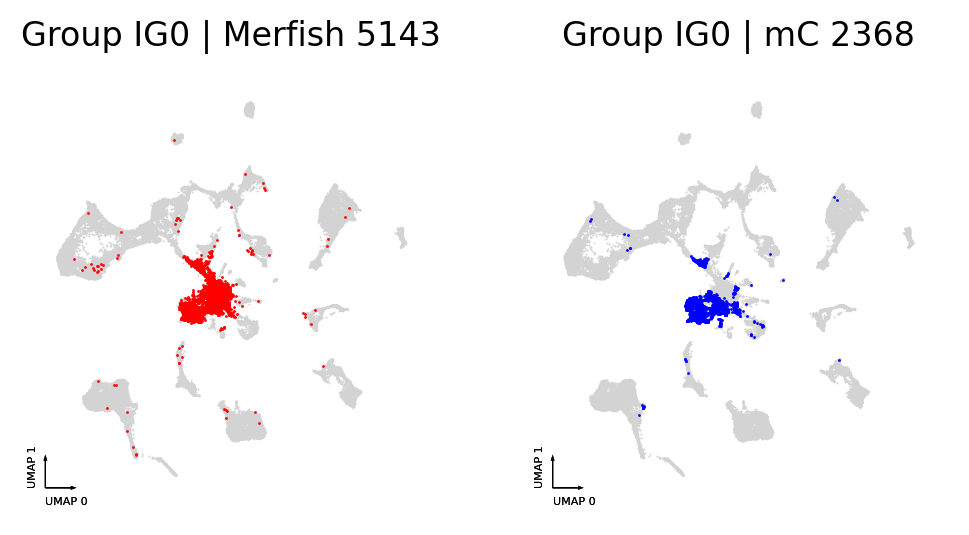

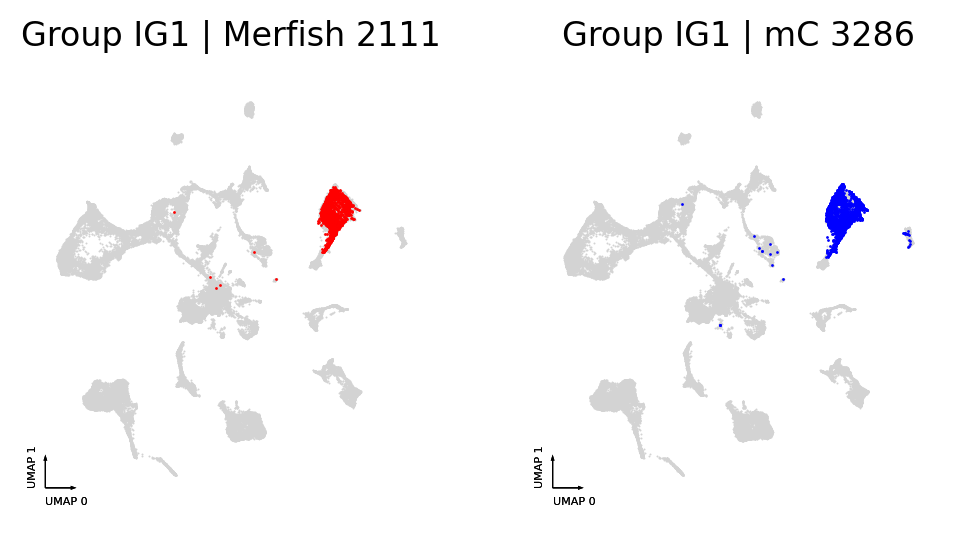

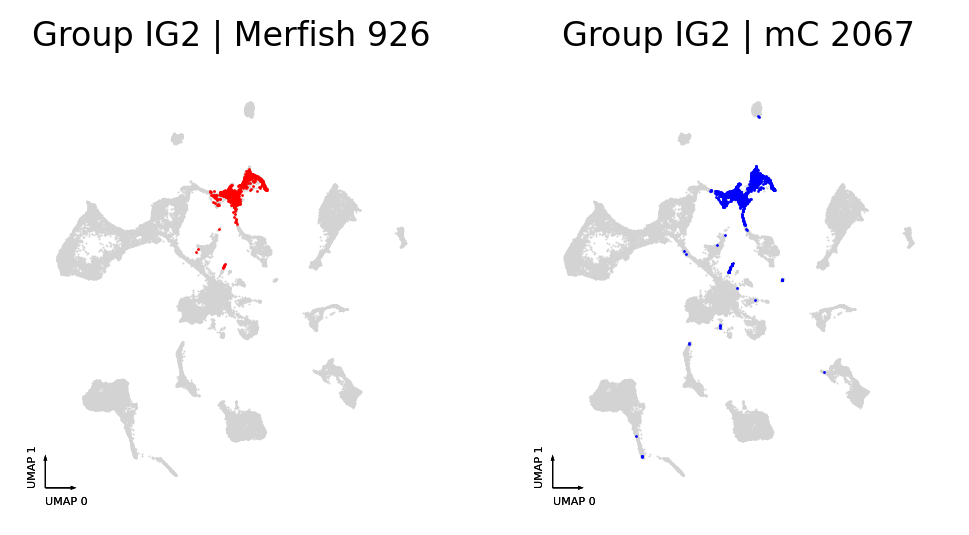

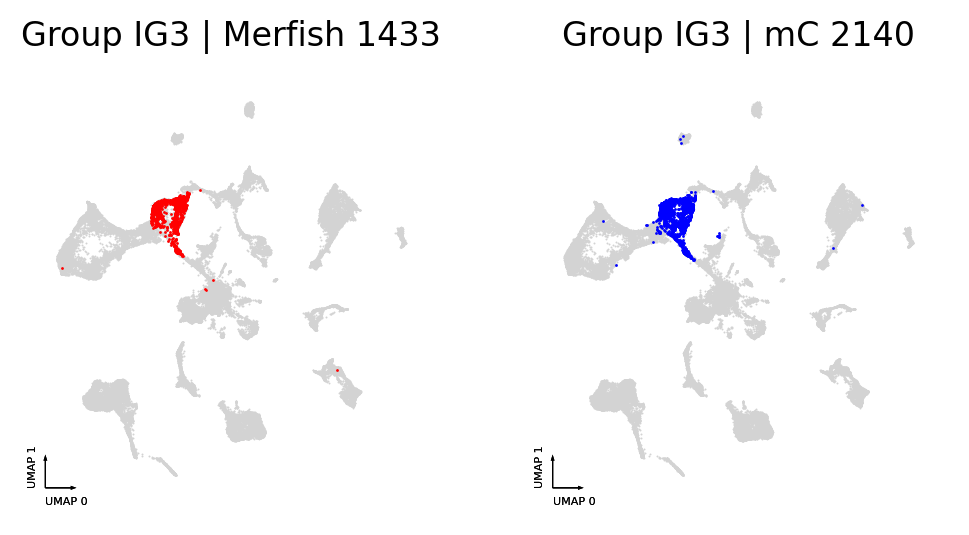

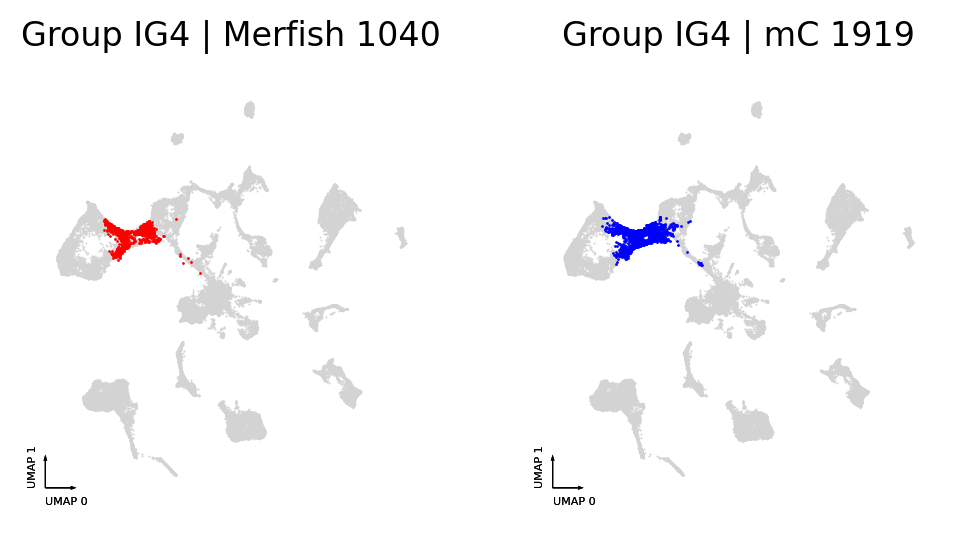

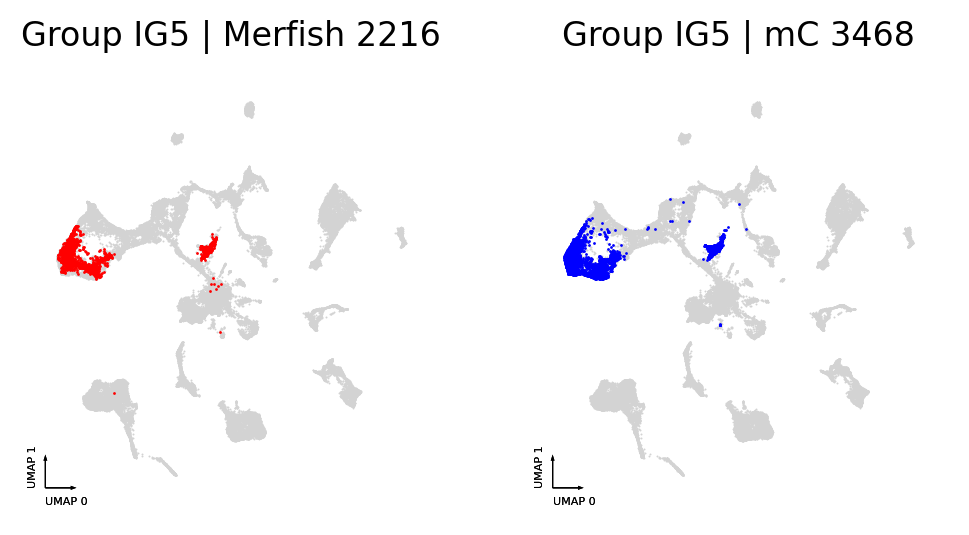

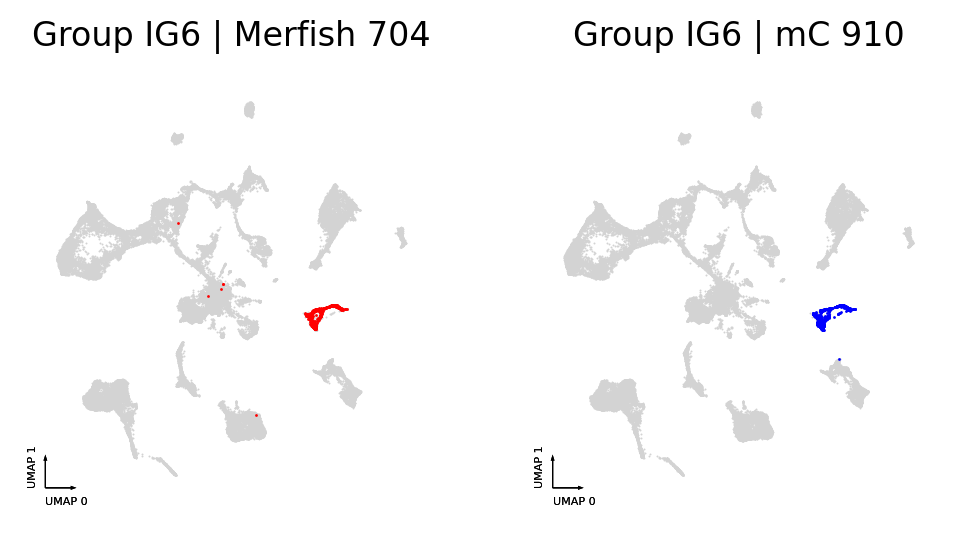

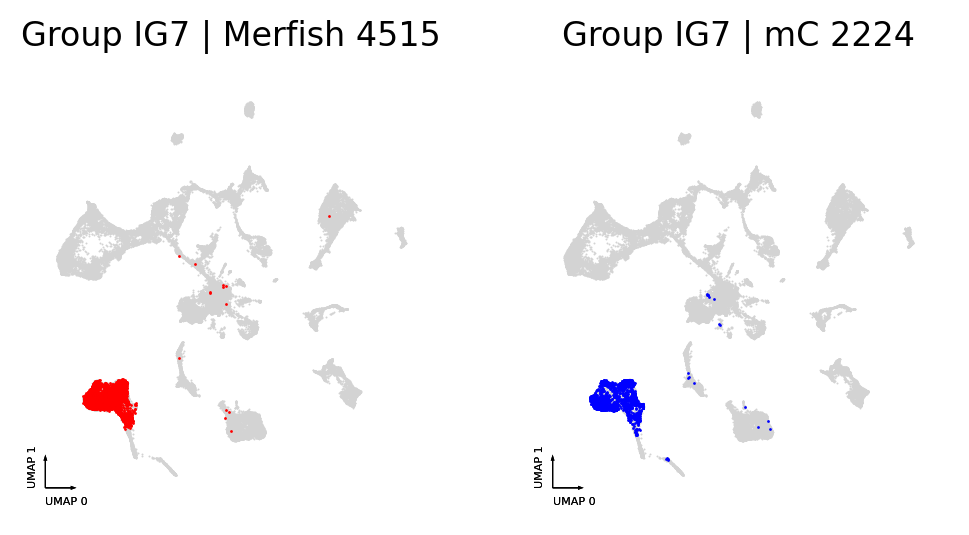

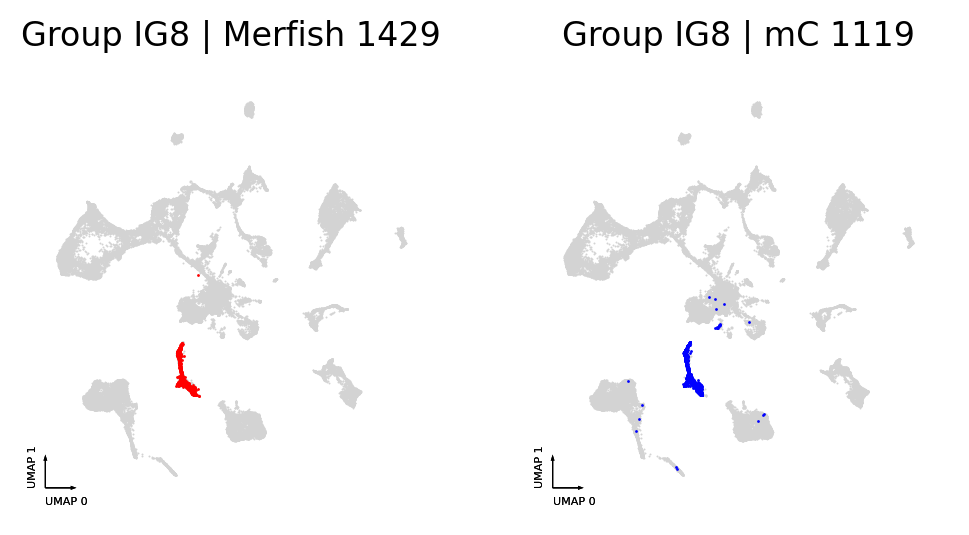

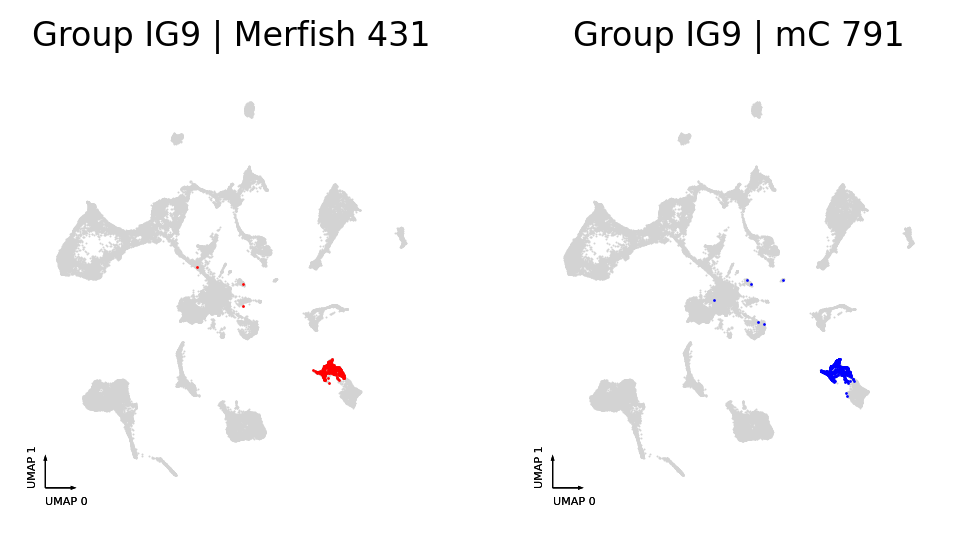

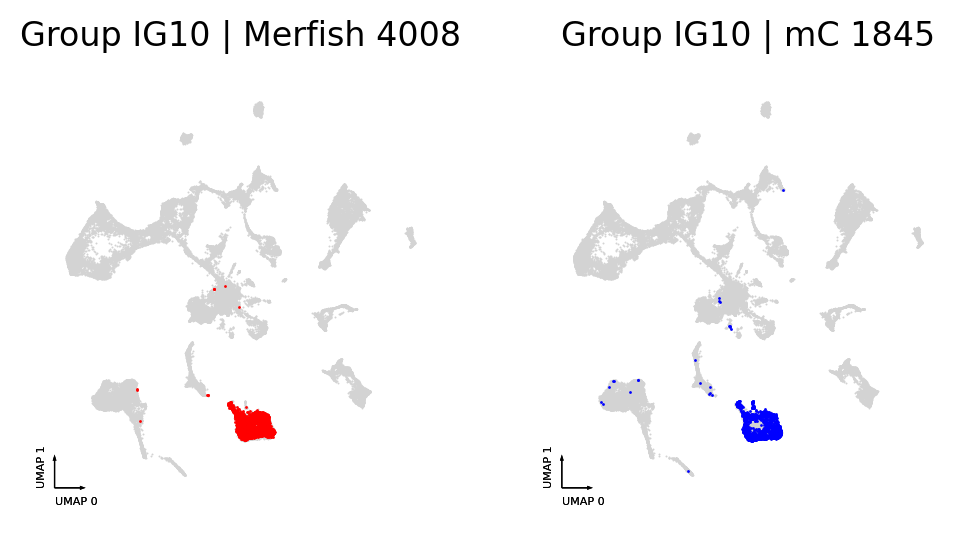

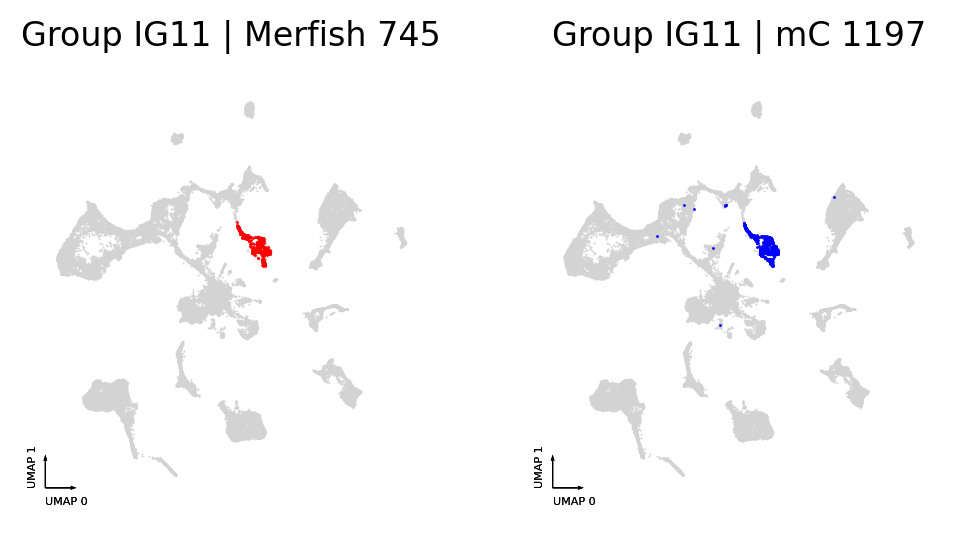

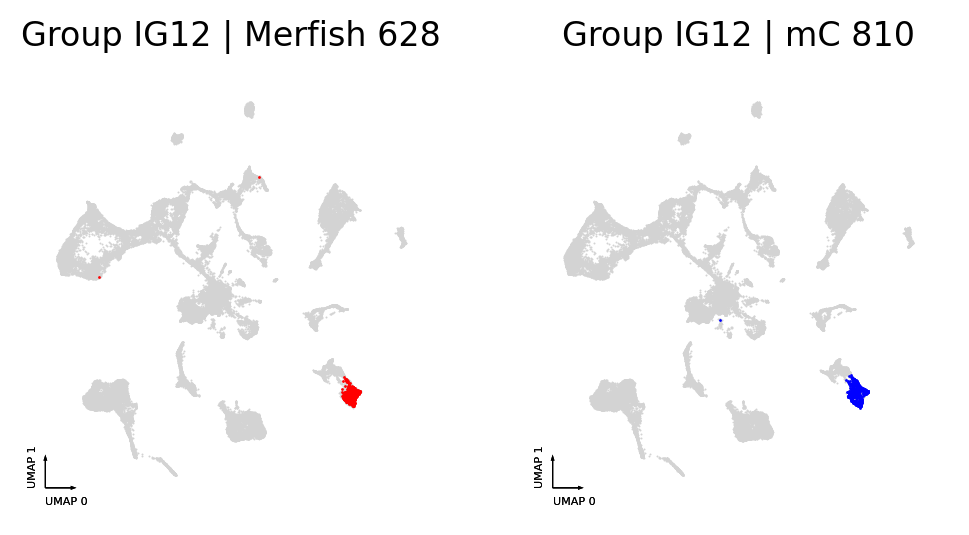

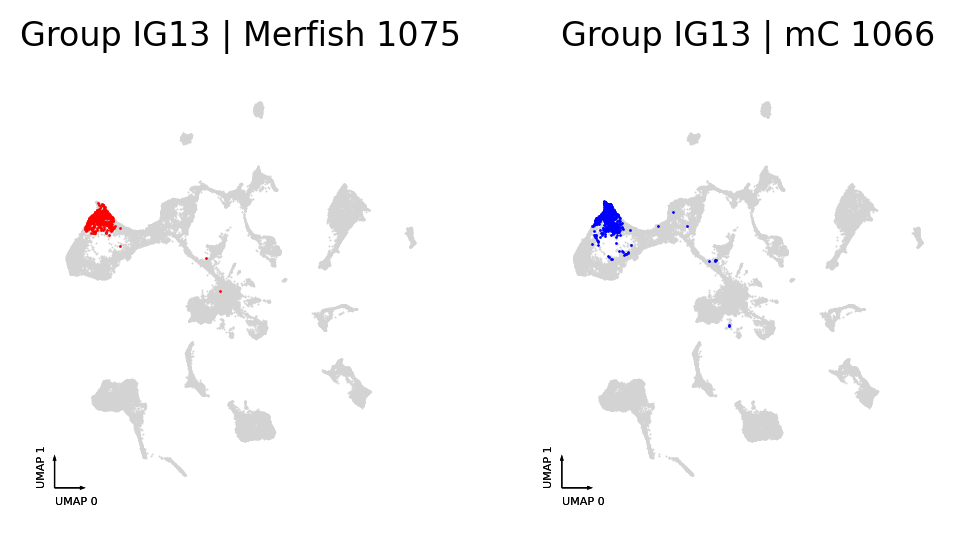

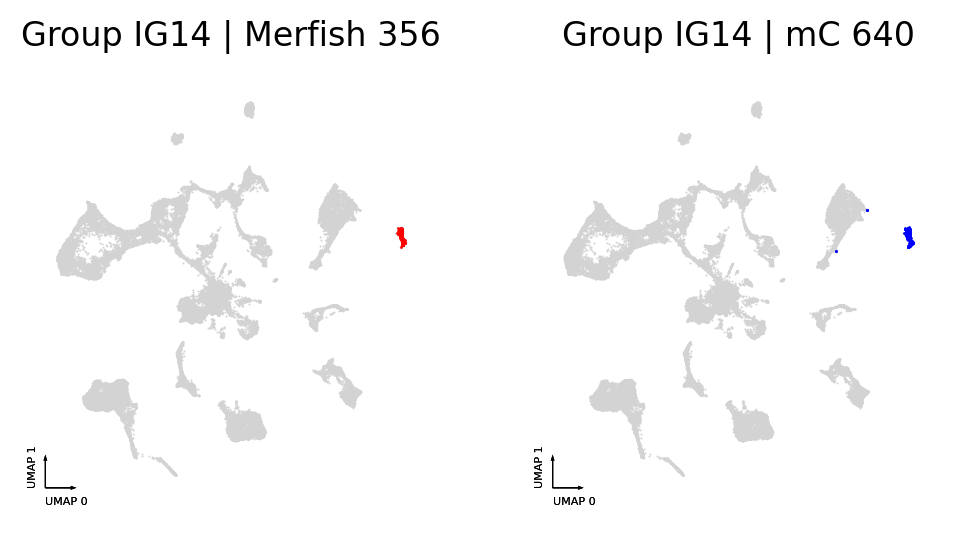

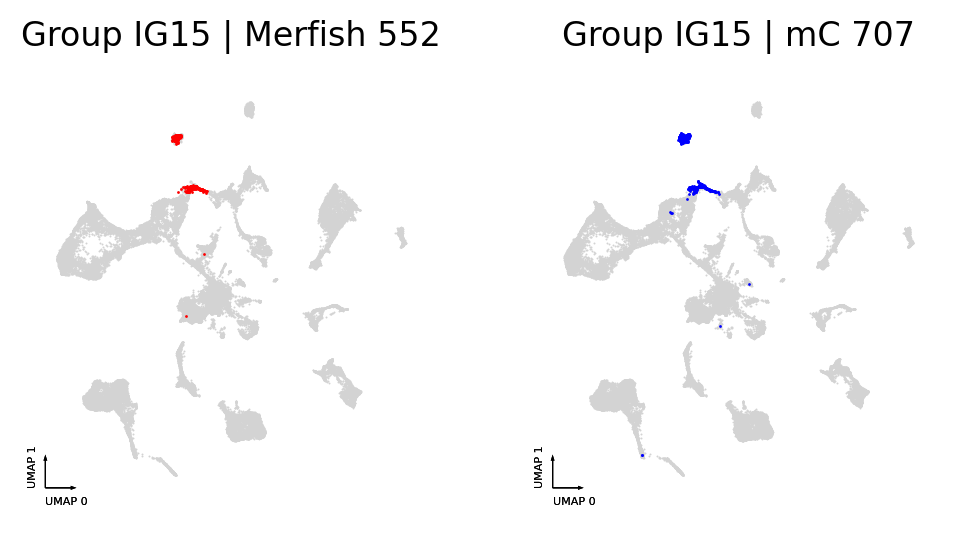

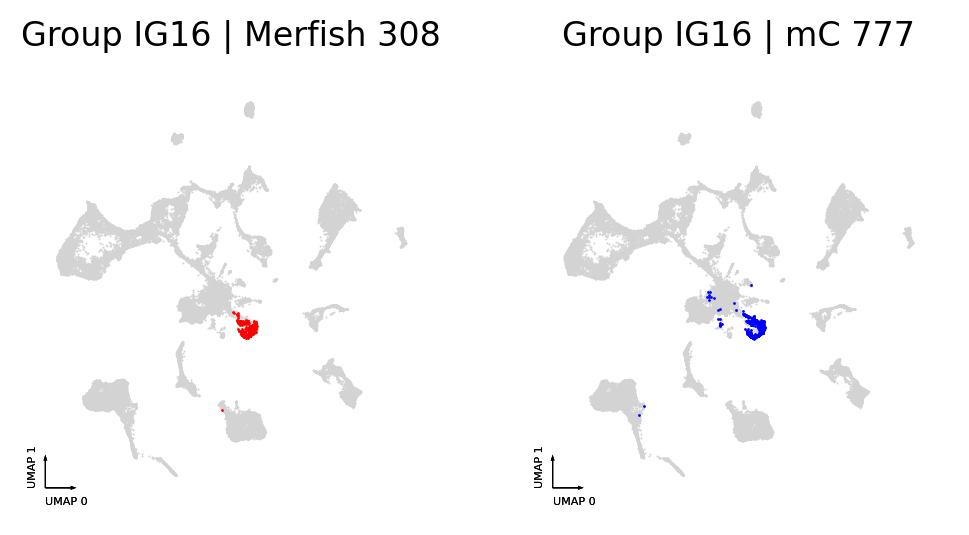

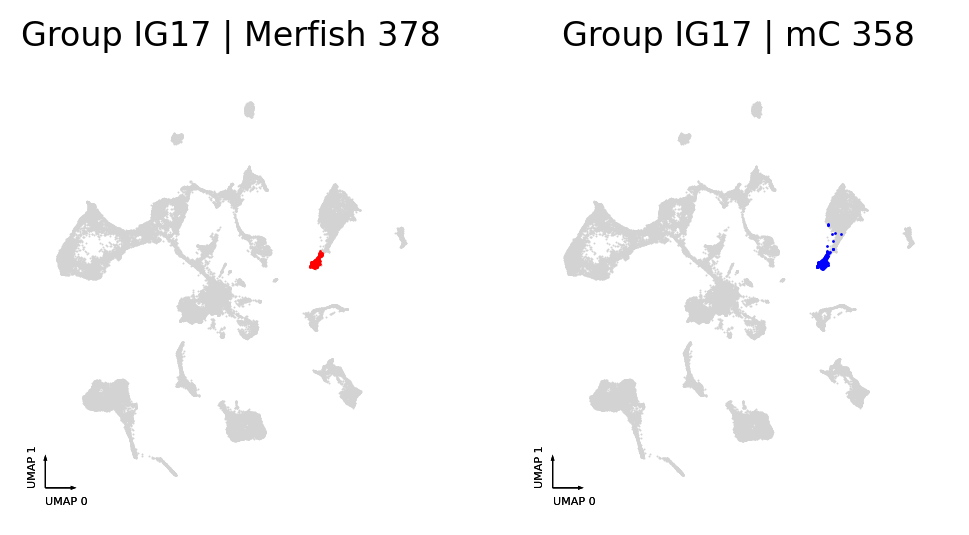

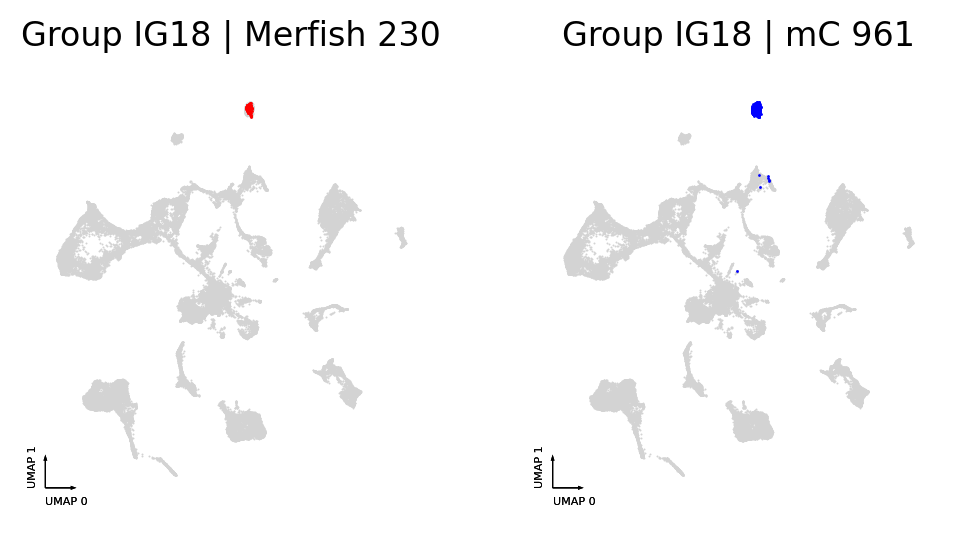

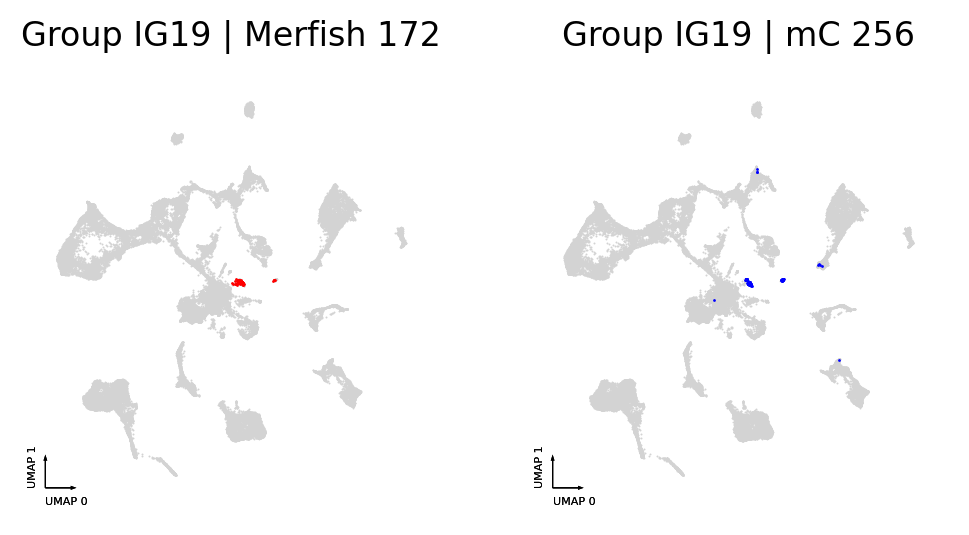

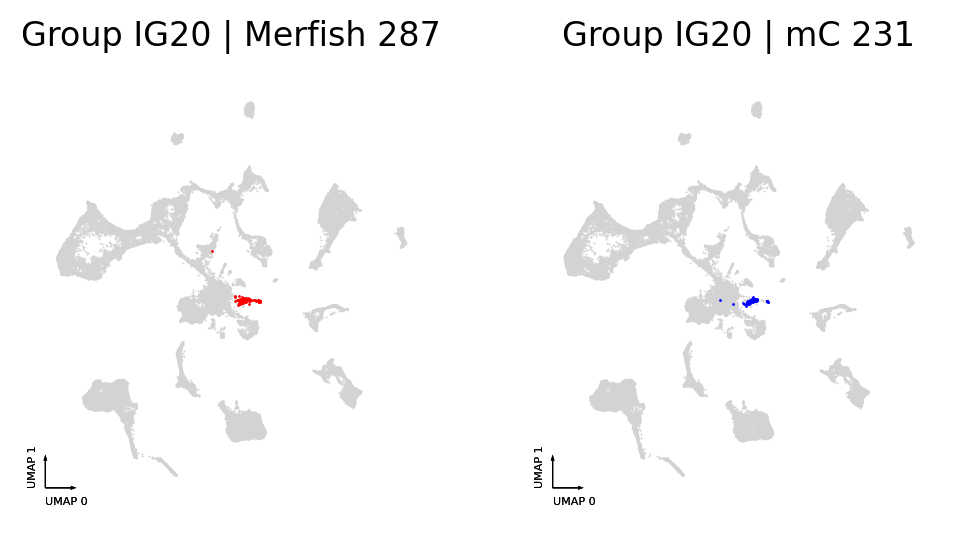

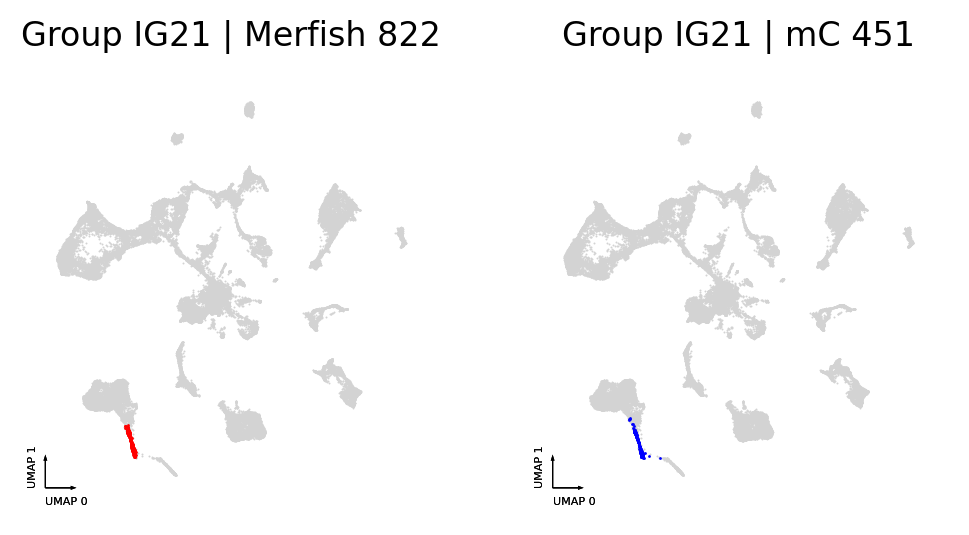

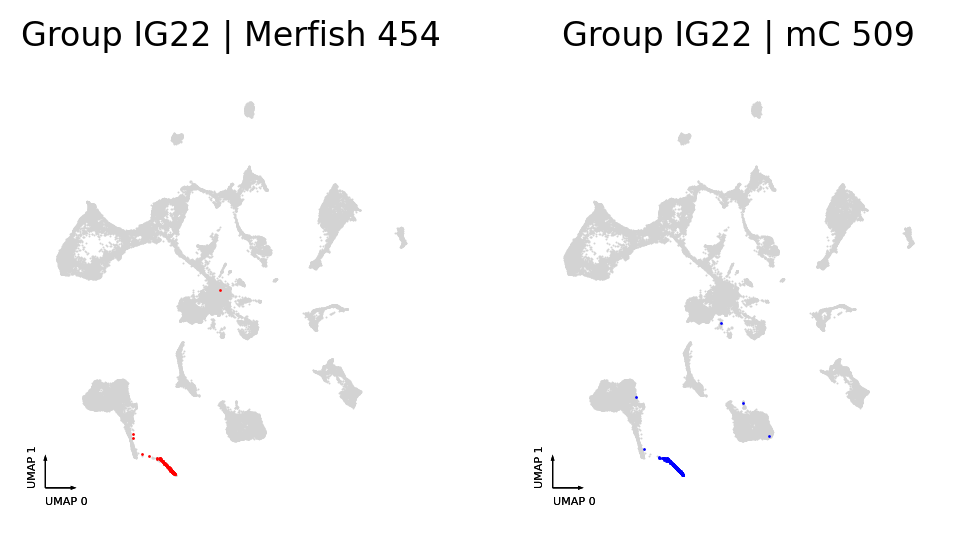

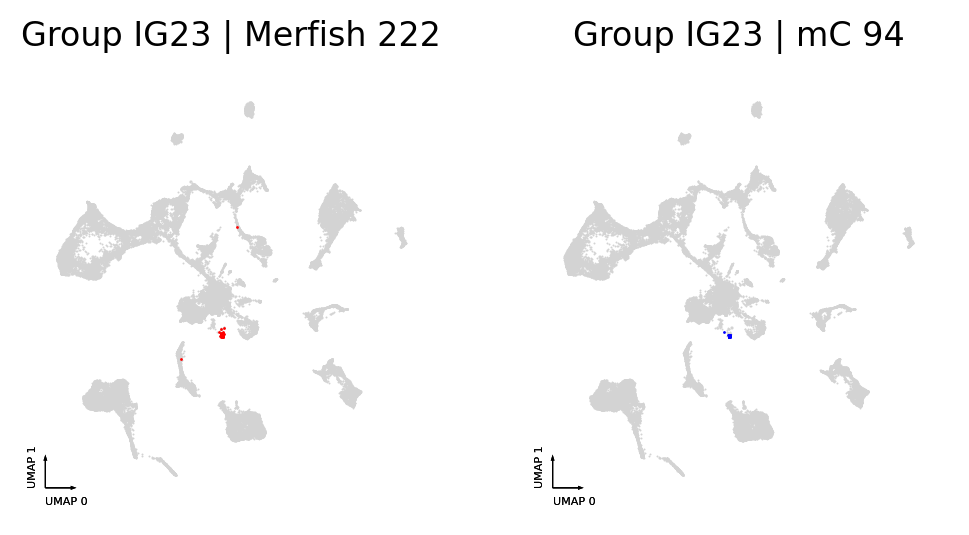

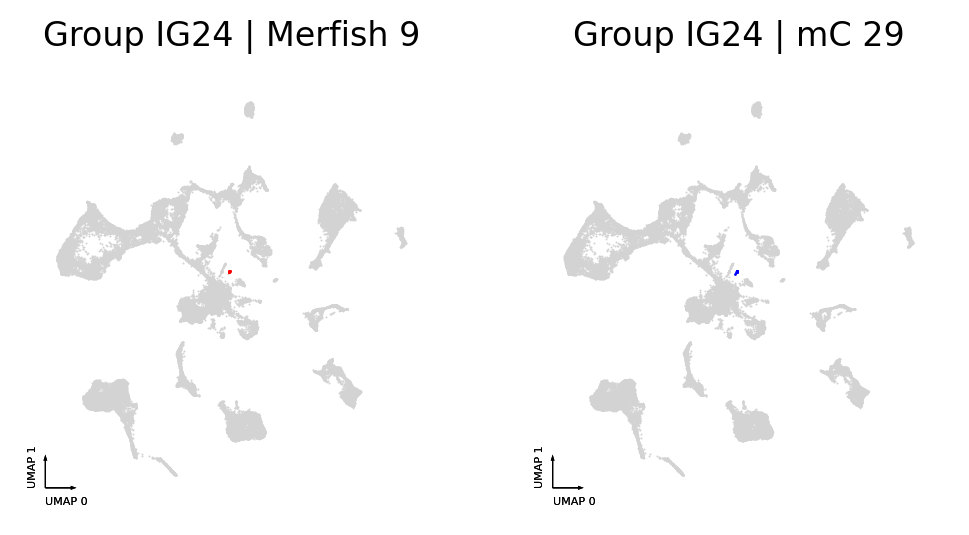

In [11]:
import matplotlib.backends.backend_pdf

adata = anndata.read_h5ad('final_with_coords.h5ad')

pdf = matplotlib.backends.backend_pdf.PdfPages("L4Region.integration_groups.pdf")

for integroup , _ in integration_group_cell.items():
    merfish_cells = _['ref']
    mc_cells = _['qry']
    
    fig, axes = plt.subplots(
        figsize=(6, 3),
        nrows=1,
        ncols=2,
        dpi=200)
    
    ax = axes[0]
    categorical_scatter(ax=ax, data=adata, coord_base="umap", color="lightgrey", max_points=None)
    categorical_scatter(
        ax=ax,
        s=1,
        data=adata[adata.obs_names.isin(merfish_cells)],
        coord_base="umap",
        color="red")
    ax.set(title=f"Group {integroup} | Merfish {len(merfish_cells)}")
    
    ax = axes[1]
    categorical_scatter(ax=ax, data=adata, coord_base="umap", color="lightgrey", max_points=None)
    categorical_scatter(
        ax=ax,
        s=1,
        data=adata[adata.obs_names.isin(mc_cells)],
        coord_base="umap",
        color="blue")
    ax.set(title=f"Group {integroup} | mC {len(mc_cells)}")
    
    pdf.savefig(fig)
pdf.close()
    